This notebook tests the mock (ELG) galaxy catalogues generated from AbacusSummit

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import glob
import os
import matplotlib.pyplot as plt

Read in file 

In [2]:
# hod model number
model_no = 3

z_in = 0.800#0.576

# HOD directory on gosling1
hod_dir = "/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/z%.3f/model_%d_rsd/"%(z_in,model_no)

sats_fns = sorted(glob.glob(hod_dir+"*sats*"))
cent_fns = sorted(glob.glob(hod_dir+"*cent*"))

print(len(cent_fns),len(sats_fns))

def load_gals(fns,dim):

    for fn in fns:
        tmp_arr = np.fromfile(fn).reshape(-1,dim)
        try:
            gal_arr = np.vstack((gal_arr,tmp_arr))
        except:
            gal_arr = tmp_arr
            
    return gal_arr

sats_arr = load_gals(sats_fns,dim=9)
cent_arr = load_gals(cent_fns,dim=9)

# first three columns of file are positions, next are velocities, then halo index and finally halo mass
sats_pos = sats_arr[:,0:3]
cent_pos = cent_arr[:,0:3]
sats_mass = sats_arr[:,-1]
cent_mass = cent_arr[:,-1]

print(sats_pos.shape)
print(cent_pos.shape)

print(f'central pos min {cent_pos.min()}')
print(f'central pos max {cent_pos.max()}')
print(f'sat pos min {sats_pos.min()}')
print(f'sat pos max {sats_pos.max()}')

x_min = 0
x_max = x_min+80.
i = 1
j = 2
k = 0
sel_cent = (cent_pos[:,k] > x_min) & (cent_pos[:,k] < x_max)
sel_sats = (sats_pos[:,k] > x_min) & (sats_pos[:,k] < x_max)

1 1
(363975, 3)
(417207, 3)
central pos min -14.433748245239258
central pos max 3995.74951171875
sat pos min -17.98533058166504
sat pos max 2022.9422607421875


In [5]:
print("number of centrals in cross section = ",np.sum(sel_cent))
print("number of satellites in cross section = ",np.sum(sel_sats))

number of centrals in cross section =  17428
number of satellites in cross section =  15402


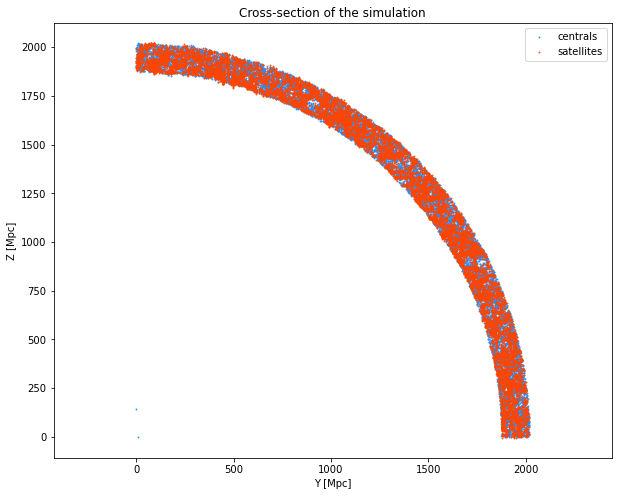

In [6]:
plt.figure(figsize=(10,8))
plt.title("Cross-section of the simulation")
plt.scatter(cent_pos[sel_cent,i],cent_pos[sel_cent,j],color='dodgerblue',s=1,alpha=0.8,label='centrals')
plt.scatter(sats_pos[sel_sats,i],sats_pos[sel_sats,j],color='orangered',s=1,alpha=0.8,label='satellites')
plt.axis('equal')
plt.xlabel('Y [Mpc]')
plt.ylabel('Z [Mpc]')
plt.legend(loc = 'best')
#plt.savefig("scatter.png")
plt.show()

Import n(z) model

In [42]:
home='/mnt/store1/tkarim/cmb_lensing/data/'
fname='nz_blanc.txt'
nz = pd.read_csv(home + fname)

#clip range to 0.45 <= z <= 1.7
zrange_low = 0.45; zrange_high = 1.41

def flag(array, zrange_low = zrange_low, zrange_high = zrange_high):
    """Returns flags to clip data array into desired redshift range"""
    
    return (array >= zrange_low) & (array <= zrange_high)

#select objects in redshift range
nz = nz[flag(nz['Redshift_mid'])]
zmid = nz['Redshift_mid']
dndzddeg2 = nz['dndz/deg^2']

Import area(z) model which tells us what is the effective sky area coverage as a function of redshift

In [43]:
dirname = '/mnt/gosling1/boryanah/light_cone_catalog/sky_coverage/'
zs_mt = np.load(dirname + "zs_mt.npy")
fs_sky = np.load(dirname + "fs_sky.npy")

#clip the file to be in the redshift range; order matters since we are using zs_mt
fs_sky = fs_sky[flag(zs_mt)]
zs_mt = zs_mt[flag(zs_mt)]

Text(0, 0.5, 'deg$^2$')

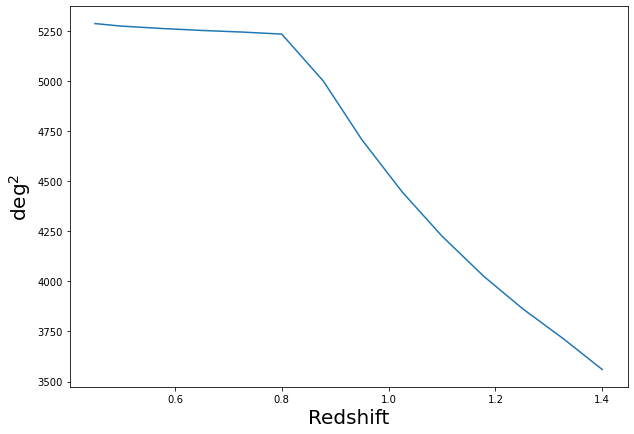

In [44]:
fs = 20; fsize = (10, 7)
plt.figure(figsize = fsize)
plt.plot(zs_mt, fs_sky)
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel(r"deg$^2$", fontsize = fs)

In [70]:
#calculate the number of objects per redshift bin 
abacus_area = fs_sky
dn = dndzddeg2 * nz['Bin_width'] * abacus_area

In [71]:
def nz_plotter(z, count, xlabel, ylabel, figsize = (10, 7), fs = 20):
    """generates nz plots based on redshift and counts"""
    plt.figure(figsize=figsize)
    plt.plot(z, count)
    plt.xlabel(xlabel, fontsize = fs)
    plt.ylabel(ylabel, fontsize = fs) 

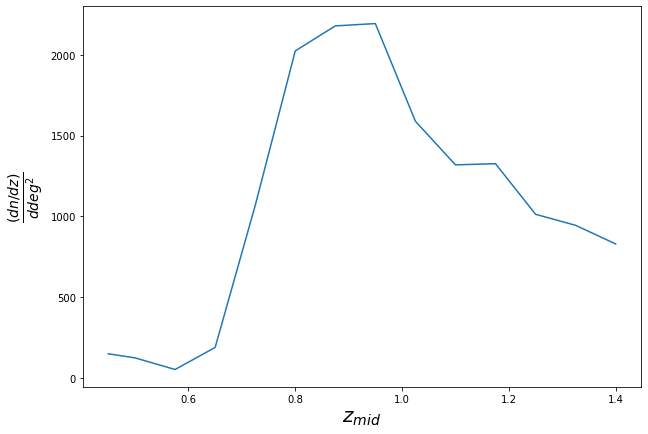

In [72]:
nz_plotter(zmid, dndzddeg2, r"$z_{mid}$", r"$\frac{(dn/dz)}{ddeg^2}$")

Convert `dndzddeg2` to `dn` to get the number of objects in a given redshift bin

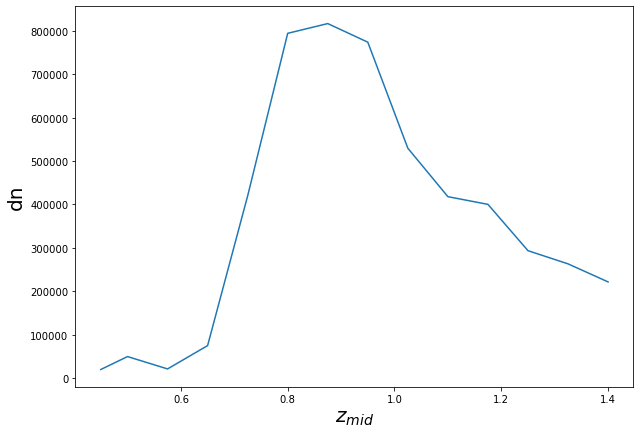

In [73]:
nz_plotter(zmid, dn, r"$z_{mid}$", "dn")

In [74]:
print(f'Total number of galaxies EXPECTED in this simulation in the redshift range {zrange_low} <= z <= {zrange_high}: {np.sum(dn)}')

Total number of galaxies EXPECTED in this simulation in the redshift range 0.45 <= z <= 1.41: 5096400.087795739


In [75]:
#Check if the total expected number of ELGs based on this dndzddeg2 yields DESI
np.sum(dndzddeg2 * nz['Bin_width'] * 14000)

15648397.557380501

Determine `zmid` for the light cone catalogues

In [76]:
hod_files = !ls /mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/

In [77]:
zmid_abacus = [np.float(redz[1:]) for redz in hod_files]
zmid_abacus = np.array(zmid_abacus)

In [78]:
zmid_abacus

array([0.45 , 0.5  , 0.576, 0.651, 0.726, 0.8  , 0.878, 0.95 , 1.026,
       1.1  , 1.179, 1.251, 1.327, 1.4  ])

Count the number of ELGs per redshift bin in AbacusSummit based on HOD

In [79]:
def gal_count_abacus(model_no, z_in):
    """Outputs the number of ELGs per Abacus redshift bin
    
    Inputs
        model_no : HOD model number
        z_in : redshift bin
        
    Outputs
        galaxy_tot : Total number of ELGs in redshift bin z_in based on HOD model_no
    """
    
    # HOD directory on gosling1
    hod_dir = "/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/z%.3f/model_%d_rsd/"%(z_in,model_no)
    
    sats_fns = sorted(glob.glob(hod_dir+"*sats*"))
    cent_fns = sorted(glob.glob(hod_dir+"*cent*"))
    
    def load_gals(fns,dim):

        for fn in fns:
            tmp_arr = np.fromfile(fn).reshape(-1,dim)
            try:
                gal_arr = np.vstack((gal_arr,tmp_arr))
            except:
                gal_arr = tmp_arr
                
        return gal_arr

    sats_arr = load_gals(sats_fns,dim=9)
    cent_arr = load_gals(cent_fns,dim=9)
    
    galaxy_tot = sats_arr.shape[0] + cent_arr.shape[0]
    
    return galaxy_tot

In [80]:
dn_abacus = []

for z in zmid_abacus:
    dn_abacus.append(gal_count_abacus(model_no=3, z_in = z))
    
dn_abacus = np.array(dn_abacus)

Text(0, 0.5, 'dN')

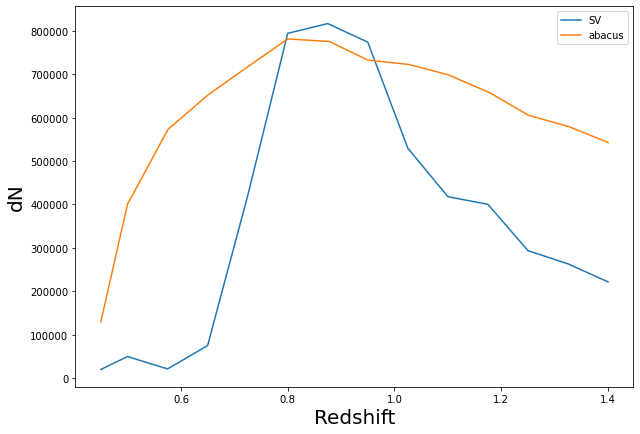

In [81]:
plt.figure(figsize = fsize)
plt.plot(zmid, dn, label = 'SV')
plt.plot(zmid_abacus, dn_abacus, label = 'abacus')
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("dN", fontsize = fs)

Text(0, 0.5, 'Downsampling factor')

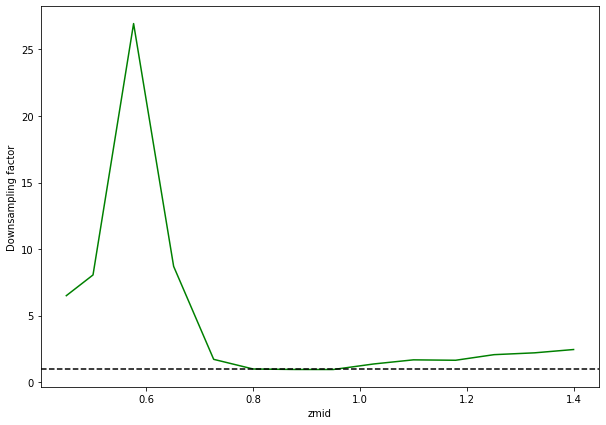

In [82]:
#calculate downsampling factor
downsample_factor = dn_abacus/dn

plt.figure(figsize = (10, 7))
plt.plot(zmid_abacus, downsample_factor, c = 'g')
plt.axhline(1, ls = "--", c = 'k')
plt.xlabel("zmid")
plt.ylabel("Downsampling factor")

In [85]:
downsample_factor

1      6.496013
2      8.053099
3     26.946001
4      8.697714
5      1.710242
6      0.983664
7      0.949434
8      0.946807
9      1.364650
10     1.672239
11     1.641388
12     2.062111
13     2.199944
14     2.448392
dtype: float64

In [86]:
1/downsample_factor

1     0.153941
2     0.124176
3     0.037111
4     0.114973
5     0.584713
6     1.016607
7     1.053259
8     1.056182
9     0.732789
10    0.598001
11    0.609241
12    0.484940
13    0.454557
14    0.408431
dtype: float64